# Описание проекта

__ЦЕЛЬ__

Определение температуры стали после достижения целевого химического состава (Целевой МАЕ 6 градусов).

__ПРОЦЕСС__

Сталь обрабатывают в металлическом ковше. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

__АЛГОРИТМ__
- Измеряют температуру стали и производят её химический анализ;
- Потом температуру на несколько минут повышают;
- Добавляют легирующие материалы  (сыпучие, проволочные материалы);
- Продувают сплав инертным газом;
- Перемешивают и снова проводят измерения. 

Цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки. Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

__Импорт библиотек__

In [1]:
import pandas as pd
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMRegressor
from catboost import CatBoost, CatBoostRegressor, Pool
import xgboost as xgb

# Предобработка данных

Чтение данных

In [2]:
try:
    # данные об электродах
    data_arc = pd.read_csv('datasets/final_steel/data_arc.csv')
    # данные о подаче сыпучих материалов (объём)
    data_bulk = pd.read_csv('datasets/final_steel/data_bulk.csv')
    # данные о подаче сыпучих материалов (время)
    data_bulk_time = pd.read_csv('datasets/final_steel/data_bulk_time.csv')
    # данные о продувке сплава газом
    data_gas = pd.read_csv('datasets/final_steel/data_gas.csv')
    # результаты измерения температуры
    data_temp = pd.read_csv('datasets/final_steel/data_temp.csv')
    # данные о проволочных материалах (объём)
    data_wire = pd.read_csv('datasets/final_steel/data_wire.csv')
    # данные о проволочных материалах (время)
    data_wire_time = pd.read_csv('datasets/final_steel/data_wire_time.csv')
    
except:
    data_arc = pd.read_csv('data_arc.csv')
    data_bulk = pd.read_csv('data_bulk.csv')
    data_bulk_time = pd.read_csv('data_bulk_time.csv')
    data_gas = pd.read_csv('data_gas.csv')
    data_temp = pd.read_csv('data_temp.csv')
    data_wire = pd.read_csv('data_wire.csv')
    data_wire_time = pd.read_csv('data_wire_time.csv')

## Данные об электродах

In [3]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


Переименуем столбцы

In [4]:
data_arc.rename(columns = {'Начало нагрева дугой':'start_heating', 
                           'Конец нагрева дугой':'end_heating', 
                           'Активная мощность':'active_power', 
                           'Реактивная мощность':'reactive_power'}, inplace = True)
data_arc.tail()

,key,start_heating,end_heating,active_power,reactive_power
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768
14875,3241,2019-09-01 04:34:47,2019-09-01 04:36:08,0.306580,0.196708


In [5]:
data_arc['key'].nunique()

3214

In [6]:
data_arc.duplicated().sum()

0

Рассмотрим распределение мощностей

<AxesSubplot:xlabel='active_power', ylabel='Count'>

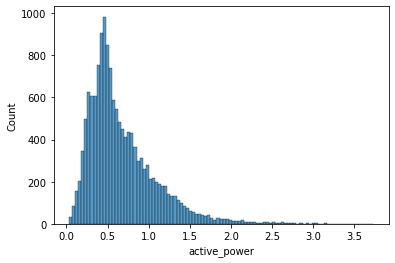

In [7]:
sns.histplot(data = data_arc, x = 'active_power', bins = 'auto')

<AxesSubplot:xlabel='reactive_power', ylabel='Count'>

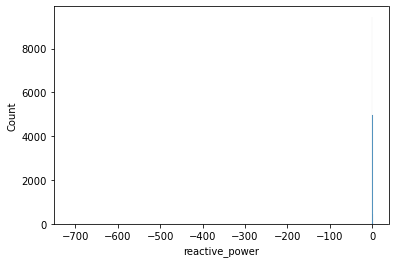

In [8]:
sns.histplot(data = data_arc, x = 'reactive_power', bins = 1000)

Исключим из данных выбросы по реактивной мощности

<AxesSubplot:xlabel='reactive_power', ylabel='Count'>

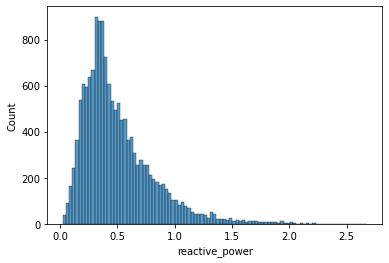

In [9]:
data_arc = data_arc[data_arc['reactive_power'] > 0]
sns.histplot(data = data_arc, x = 'reactive_power', bins = 'auto')

In [10]:
print('Первый нагрев', data_arc['start_heating'].min(), '-', data_arc['end_heating'].min())
print('Последний нагрев', data_arc['start_heating'].max(), '-', data_arc['end_heating'].max())

Первый нагрев 2019-05-03 11:02:14 - 2019-05-03 11:06:02
Последний нагрев 2019-09-01 04:34:47 - 2019-09-01 04:36:08


__Заметка "данные об электродах"__

- Пропуски в данных об электродах отсутствуют. Явных дубликатов не имеется
- Всего в данных 3214 партий (нумерация с 1-ого по 3 241-й)
- Количество фактических нагревов - 14 875 шт
- Имеется выброс в реактивной мощности -715
- Данные представлены с 3 мая по 1 сентября

## Данные о подаче сыпучих материалов

In [11]:
display(data_bulk_time.tail(),data_bulk_time.info(),
        print(),
        data_bulk.tail(), data_bulk.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 04:05:34,2019-09-01 04:05:34


None

None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,52.0


None

In [12]:
data_bulk['key'].nunique()

3129

In [13]:
data_bulk_time['key'].nunique()

3129

In [14]:
data_bulk.duplicated().sum()

0

In [15]:
data_bulk_time.duplicated().sum()

0

<AxesSubplot:>

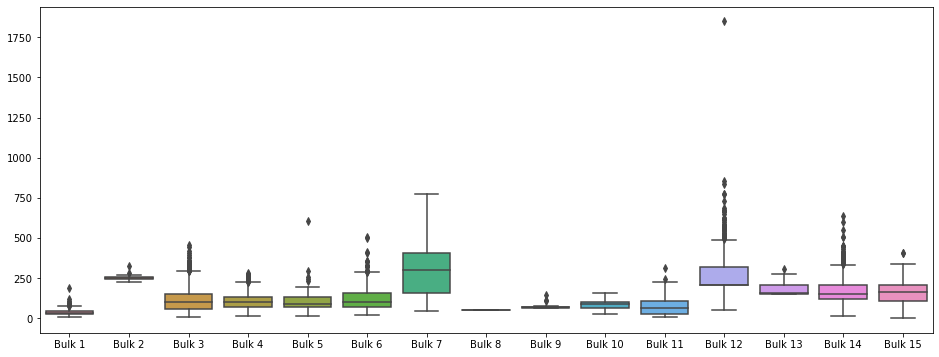

In [16]:
plt.figure(figsize=(16, 6))
sns.boxplot(data = data_bulk.drop(columns = 'key'))

Удалим выброс по материалу №12

<AxesSubplot:>

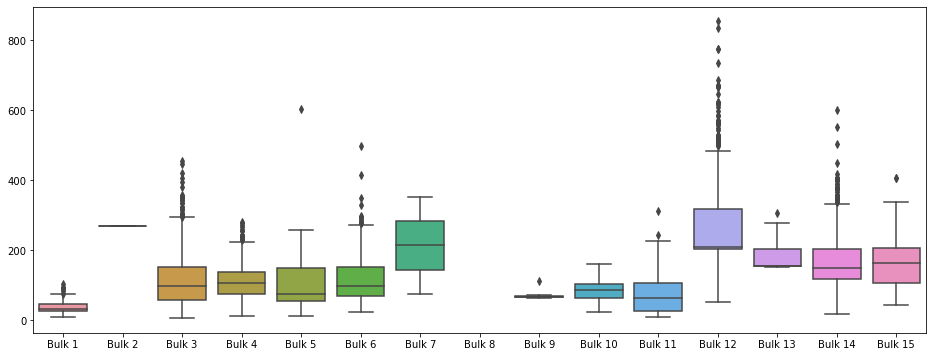

In [17]:
#data_bulk.fillna(0, inplace = True)
data_bulk_time = data_bulk_time[data_bulk['Bulk 12'] < 1000]
data_bulk = data_bulk[data_bulk['Bulk 12'] < 1000]

plt.figure(figsize=(16, 6))
sns.boxplot(data = data_bulk.drop(columns = 'key'))

In [18]:
for i in range(1, 16):
    print(f'Период подачи материала №{i}', data_bulk_time[f'Bulk {i}'].dropna().min(), 
          ' - ', data_bulk_time[f'Bulk {i}'].dropna().max())

Период подачи материала №1 2019-05-03 17:50:19  -  2019-08-30 23:01:32
Период подачи материала №2 2019-08-08 17:34:38  -  2019-08-08 17:34:38
Период подачи материала №3 2019-05-03 20:13:36  -  2019-08-31 23:39:11
Период подачи материала №4 2019-05-03 11:21:30  -  2019-08-30 17:36:30
Период подачи материала №5 2019-05-09 06:47:16  -  2019-08-28 09:01:08
Период подачи материала №6 2019-05-03 18:52:57  -  2019-09-01 01:51:58
Период подачи материала №7 2019-06-15 00:42:38  -  2019-08-08 17:34:38
Период подачи материала №8 nan  -  nan
Период подачи материала №9 2019-05-14 00:04:56  -  2019-07-18 17:35:46
Период подачи материала №10 2019-05-06 18:04:52  -  2019-08-30 01:30:42
Период подачи материала №11 2019-05-05 16:45:05  -  2019-08-31 16:00:49
Период подачи материала №12 2019-05-03 11:03:52  -  2019-09-01 01:39:41
Период подачи материала №13 2019-05-05 00:39:35  -  2019-08-26 20:31:16
Период подачи материала №14 2019-05-03 11:03:52  -  2019-09-01 01:33:25
Период подачи материала №15 2019-

Text(0.5, 1.0, 'Пропуски в данных')

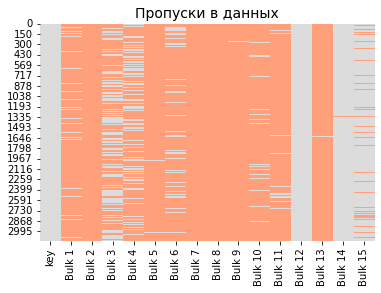

In [19]:
colours = ['Gainsboro', 'LightSalmon'] 
sns.heatmap(data_bulk_time.isnull(), cmap=sns.color_palette(colours), cbar = False)
plt.title('Пропуски в данных', fontsize=14)

Text(0.5, 1.0, 'Пропуски в данных')

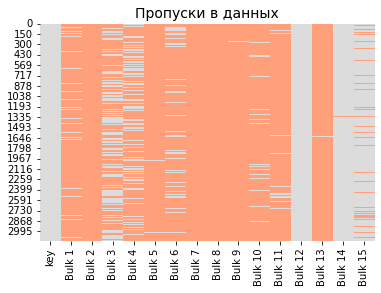

In [20]:
sns.heatmap(data_bulk.isnull(), cmap=sns.color_palette(colours), cbar = False)
plt.title('Пропуски в данных', fontsize=14)

__Заметка "данные о подаче сыпучих материалов"__

- Пропуски в данных имеются и вероятно связаны с отствуием процесса легирования тем или иным материалом. Количество одинаковое по двум датасетам
- Явных дубликатов не имеется
- Всего в данных 3129 партий (нумерация с 1-ого по 3 241-й)
- Сильных выбросов нет
- Всего 15 видов сыпучих материалов. Самые редко используемые из них - 8й и 9й

## Данные о продувке сплава газом

Рассмотрим через профайлинг

In [21]:
profile = data_gas.profile_report(title = 'Данные о продувке сплава газом', progress_bar = False)
profile.to_widgets()

In [22]:
data_gas.rename(columns = {'Газ 1':'gas'}, inplace = True)
data_gas.tail()

,key,gas
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103
3238,3241,12.680959


__Заметка "данные о продувке сплава газом"__

- Пропуски в данных отсутствуют. Количество одинаковое по двум датасетам
- Явных дубликатов не имеется
- Всего в данных 3239 партий (нумерация с 1-ого по 3 241-й)
- Выбросов нет

## Результаты измерения температуры

In [23]:
profile = data_temp.profile_report(title='Результаты измерения температуры', progress_bar=False)
profile.to_widgets()

In [24]:
print(f'Период замера температуры', data_temp['Время замера'].min(),' - ', data_temp['Время замера'].max())

Период замера температуры 2019-05-03 11:16:18  -  2019-09-01 04:38:08


In [25]:
data_temp.rename(columns = {'Время замера':'measurement_time',
                           'Температура':'temperature'}, inplace = True)
data_temp.tail()

,key,measurement_time,temperature
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN
15906,3241,2019-09-01 04:38:08,NaN


<AxesSubplot:>

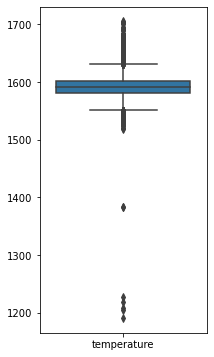

In [26]:
plt.figure(figsize=(3, 6))
sns.boxplot(data = data_temp.drop(columns = 'key'))

Удалим выбросы

In [27]:
data_temp = data_temp[data_temp['temperature'] >= 1500]

__Заметка "результаты измерения температуры"__

- Пропуски в данных имеются - по температуре (18.2 %) 
- Явных дубликатов не имеется
- Всего в данных 3216 партий (нумерация с 1-ого по 3 241-й)
- Выбросы удалены

## Данные о проволочных материалах

In [28]:
profile = data_wire.profile_report(title='Данные о проволочных материалах', progress_bar=False)
profile.to_widgets()

<AxesSubplot:>

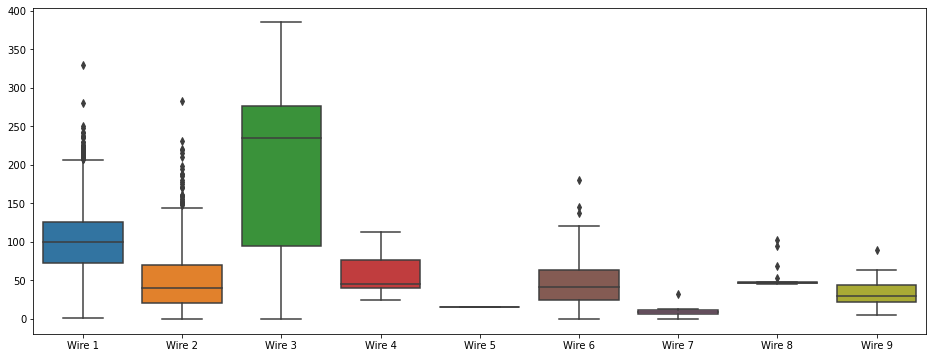

In [29]:
plt.figure(figsize=(16, 6))
sns.boxplot(data = data_wire.drop(columns = 'key'))

In [30]:
for i in range(1, 10):
    print(f'Период подачи проволочного материала №{i}', data_wire_time[f'Wire {i}'].dropna().min(), 
          ' - ', data_wire_time[f'Wire {i}'].dropna().max())

Период подачи проволочного материала №1 2019-05-03 11:11:41  -  2019-09-01 04:16:01
Период подачи проволочного материала №2 2019-05-03 13:32:06  -  2019-08-31 18:50:15
Период подачи проволочного материала №3 2019-05-04 04:47:53  -  2019-08-28 02:11:18
Период подачи проволочного материала №4 2019-05-07 08:48:23  -  2019-08-08 12:03:12
Период подачи проволочного материала №5 2019-08-08 16:01:07  -  2019-08-08 16:01:07
Период подачи проволочного материала №6 2019-05-07 08:37:20  -  2019-08-14 00:59:11
Период подачи проволочного материала №7 2019-07-23 12:08:44  -  2019-08-08 18:27:34
Период подачи проволочного материала №8 2019-05-14 00:03:32  -  2019-08-11 15:09:29
Период подачи проволочного материала №9 2019-05-04 16:09:11  -  2019-08-29 03:51:31


In [31]:
#data_wire.fillna(0, inplace = True)

__Заметка "данные о проволочных материалах"__

- Пропуски в данных имеются - 75.9 % (фактически не участвовашие при легировании материалы)
- Явных дубликатов не имеется
- Всего в данных 3081 партий (нумерация с 1-ого по 3 241-й)
- Всего 9 видов проволочных материалов. Первые два из которых наиболее частые

# Объединение датасетов

Добавим длительность нагрева, возможно ее наличие в виде признака улучшит целевую метрику

In [32]:
data_arc['duration_heating'] = abs(pd.to_datetime(data_arc['end_heating']) - 
                                    pd.to_datetime(data_arc['start_heating'])) / np.timedelta64(1, 's')
data_arc.head(10)

,key,start_heating,end_heating,active_power,reactive_power,duration_heating
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148.0
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043,137.0
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914,338.0
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281,126.0
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874,210.0
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494,280.0


<AxesSubplot:xlabel='duration_heating', ylabel='active_power'>

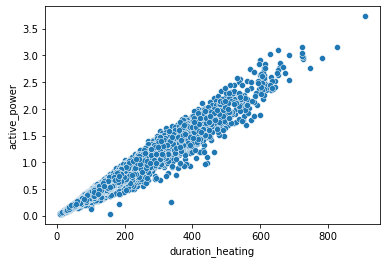

In [33]:
sns.scatterplot(data=data_arc, x="duration_heating", y="active_power")

<AxesSubplot:xlabel='duration_heating', ylabel='reactive_power'>

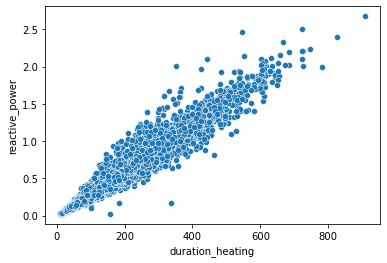

In [34]:
sns.scatterplot(data=data_arc, x="duration_heating", y="reactive_power")

Создадим сводную таблицу по процессу нагрева. Нас интересует:
- Суммарная активная и реактивная мощность, а также общая длительность нагрева
- Время начала первого нагрева и конец последнего нагрева для последующей проверки измеренных температур на предмет их корректности

In [35]:
# Сгруппируем данные по партиям
data_arc_pivot = pd.pivot_table(data_arc,
                                index='key',
                                aggfunc={'active_power': np.sum,
                                         'reactive_power': np.sum,
                                         'start_heating': np.min,
                                         'end_heating': np.max,
                                         'duration_heating': np.sum})
# Переименуем столбцы
data_arc_pivot.columns = ['sum_active_power', 'sum_duration_heating', 'last_heating',
                          'sum_reactive_power', 'first_heating']
data_arc_pivot.head()

,sum_active_power,sum_duration_heating,last_heating,sum_reactive_power,first_heating
key,,,,,
1,4.878147,1098.0,2019-05-03 11:28:37,3.183241,2019-05-03 11:02:14
2,3.052598,811.0,2019-05-03 11:53:18,1.998112,2019-05-03 11:34:14
3,2.525882,655.0,2019-05-03 12:32:19,1.599076,2019-05-03 12:06:54
4,3.209250,741.0,2019-05-03 12:57:50,2.060298,2019-05-03 12:39:37
5,3.347173,869.0,2019-05-03 13:33:55,2.252643,2019-05-03 13:11:13


Создадим сводную таблицу по замерам температуры сплава. Нас интересует:
- Время первого замера температуры и ее значение
- Время последнего замера температуры и ее значение
- Общее количество замеров, чтобы в последующем удалить партии с единичными замерами 

In [36]:
data_temp_first = data_temp[['key','measurement_time']].groupby(by='key',as_index=False).min()
data_temp_last = data_temp[['key','measurement_time']].groupby(by='key',as_index=False).max()
data_temp_count = data_temp[['key', 'temperature']].groupby(by='key',as_index=False).count()

data_temp_first = pd.merge(data_temp_first,data_temp,on=['key','measurement_time'],how='left')
data_temp_last = pd.merge(data_temp_last,data_temp,on=['key','measurement_time'],how='left')

data_temp_pivot = pd.merge(data_temp_first,data_temp_last,on=['key'],how='left')
data_temp_pivot = pd.merge(data_temp_pivot,data_temp_count,on=['key'],how='left')

data_temp_pivot.set_index('key', inplace =True)
data_temp_pivot.columns = ['first_temp_time', 'first_measurement_temp', 'last_temp_time', 'last_measurement_temp', 'count']

data_temp_pivot.tail()

,first_temp_time,first_measurement_temp,last_temp_time,last_measurement_temp,count
key,,,,,
3237,2019-08-31 22:44:04,1569.0,2019-08-31 22:44:04,1569.0,1
3238,2019-08-31 23:30:31,1584.0,2019-08-31 23:30:31,1584.0,1
3239,2019-09-01 01:31:47,1598.0,2019-09-01 01:31:47,1598.0,1
3240,2019-09-01 02:39:01,1617.0,2019-09-01 02:39:01,1617.0,1
3241,2019-09-01 04:03:30,1586.0,2019-09-01 04:03:30,1586.0,1


Удалим единичные замеры температур

In [37]:
data_temp_pivot = data_temp_pivot[data_temp_pivot['count'] > 1]
data_temp_pivot.head()

,first_temp_time,first_measurement_temp,last_temp_time,last_measurement_temp,count
key,,,,,
1,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,5
2,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0,6
3,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0,5
4,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0,3
5,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0,2


Создадим таблицу с временами первого и последнего добавления проволочных материалов

In [38]:
data_wire_time.index = data_wire_time['key']
data_wire_time.drop(columns = 'key', inplace = True)

for i in list(data_wire_time.index):
    data_wire_time.loc[i, 'first_wire_time'] = data_wire_time.loc[i].dropna().min()
    data_wire_time.loc[i, 'last_wire_time'] = data_wire_time.loc[i].dropna().max()
data_wire_time = data_wire_time.loc[:, ['first_wire_time', 'last_wire_time']]
data_wire_time.head()

,first_wire_time,last_wire_time
key,,
1,2019-05-03 11:11:41,2019-05-03 11:11:41
2,2019-05-03 11:46:10,2019-05-03 11:46:10
3,2019-05-03 12:13:47,2019-05-03 12:13:47
4,2019-05-03 12:48:05,2019-05-03 12:48:05
5,2019-05-03 13:18:15,2019-05-03 13:32:06


Аналогично по сыпучим материалам определим первую и последнюю операцию добавления

In [39]:
data_bulk_time.index = data_bulk_time['key']
data_bulk_time.drop(columns = 'key', inplace = True)

for i in list(data_bulk_time.index):
    data_bulk_time.loc[i, 'first_bulk_time'] = data_bulk_time.loc[i].dropna().min()
    data_bulk_time.loc[i, 'last_bulk_time'] = data_bulk_time.loc[i].dropna().max()
data_bulk_time = data_bulk_time.loc[:, ['first_bulk_time', 'last_bulk_time']]
data_bulk_time.head()

,first_bulk_time,last_bulk_time
key,,
1,2019-05-03 11:03:52,2019-05-03 11:21:30
2,2019-05-03 11:40:20,2019-05-03 11:46:38
3,2019-05-03 12:09:40,2019-05-03 12:31:06
4,2019-05-03 12:41:24,2019-05-03 12:48:43
5,2019-05-03 13:12:56,2019-05-03 13:18:50


Ключ к партии выведем в индексы для последующего объединения датасетов

In [40]:
data_bulk.set_index('key', inplace = True)
data_bulk.drop(columns = ['Bulk 8'], inplace = True) # пустые признаки
data_bulk.fillna(0, inplace = True)


data_gas.set_index('key', inplace = True)
data_gas.fillna(0, inplace = True)

data_wire.set_index('key', inplace = True)
data_wire.fillna(0, inplace = True)


display(data_bulk.head(),
        data_gas.head(),
        data_wire.head())

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,
1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


,gas
key,
1,29.749986
2,12.555561
3,28.554793
4,18.841219
5,5.413692


,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,
1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Объеденим датасеты в одну

In [41]:
data = pd.concat([data_arc_pivot, data_bulk, data_wire, data_gas, 
                  data_bulk_time, data_temp_pivot, data_wire_time], axis = 1)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3241 entries, 1 to 3241
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   sum_active_power        3214 non-null   float64
 1   sum_duration_heating    3214 non-null   float64
 2   last_heating            3214 non-null   object 
 3   sum_reactive_power      3214 non-null   float64
 4   first_heating           3214 non-null   object 
 5   Bulk 1                  2449 non-null   float64
 6   Bulk 2                  2449 non-null   float64
 7   Bulk 3                  2449 non-null   float64
 8   Bulk 4                  2449 non-null   float64
 9   Bulk 5                  2449 non-null   float64
 10  Bulk 6                  2449 non-null   float64
 11  Bulk 7                  2449 non-null   float64
 12  Bulk 9                  2449 non-null   float64
 13  Bulk 10                 2449 non-null   float64
 14  Bulk 11                 2449 non-null   

In [42]:
data.columns

Index(['sum_active_power', 'sum_duration_heating', 'last_heating',
       'sum_reactive_power', 'first_heating', 'Bulk 1', 'Bulk 2', 'Bulk 3',
       'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 9', 'Bulk 10', 'Bulk 11',
       'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15', 'Wire 1', 'Wire 2',
       'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9',
       'gas', 'first_bulk_time', 'last_bulk_time', 'first_temp_time',
       'first_measurement_temp', 'last_temp_time', 'last_measurement_temp',
       'count', 'first_wire_time', 'last_wire_time'],
      dtype='object')

In [43]:
pd.set_option('display.max_columns', None)
data.head()

,sum_active_power,sum_duration_heating,last_heating,sum_reactive_power,first_heating,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,gas,first_bulk_time,last_bulk_time,first_temp_time,first_measurement_temp,last_temp_time,last_measurement_temp,count,first_wire_time,last_wire_time
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.878147,1098.0,2019-05-03 11:28:37,3.183241,2019-05-03 11:02:14,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986,2019-05-03 11:03:52,2019-05-03 11:21:30,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,5.0,2019-05-03 11:11:41,2019-05-03 11:11:41
2,3.052598,811.0,2019-05-03 11:53:18,1.998112,2019-05-03 11:34:14,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561,2019-05-03 11:40:20,2019-05-03 11:46:38,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0,6.0,2019-05-03 11:46:10,2019-05-03 11:46:10
3,2.525882,655.0,2019-05-03 12:32:19,1.599076,2019-05-03 12:06:54,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793,2019-05-03 12:09:40,2019-05-03 12:31:06,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0,5.0,2019-05-03 12:13:47,2019-05-03 12:13:47
4,3.209250,741.0,2019-05-03 12:57:50,2.060298,2019-05-03 12:39:37,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219,2019-05-03 12:41:24,2019-05-03 12:48:43,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0,3.0,2019-05-03 12:48:05,2019-05-03 12:48:05
5,3.347173,869.0,2019-05-03 13:33:55,2.252643,2019-05-03 13:11:13,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692,2019-05-03 13:12:56,2019-05-03 13:18:50,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0,2.0,2019-05-03 13:18:15,2019-05-03 13:32:06


Задетектим партии, где первые замеры температуры были после первого нагрева.

In [44]:
error_key_1 = ((data['first_temp_time'] > data['first_heating']) & 
        (data['last_heating'] > data['last_temp_time']))
error_key_1.sum()

129

Задетектим партии, где после последних замеров температур еще были процессы легирования.

In [45]:
error_key_2 = ((data['last_wire_time'] > data['last_temp_time']) & 
        (data['last_bulk_time'] > data['last_temp_time']))
error_key_2.sum()

0

Итак, есть 129 партий с недостоверными для обучения замерами температур. Исключим их

In [46]:
data = data[~error_key_1]

Удалим признаки со временем, не будут участвовать в обучении

In [47]:
data.drop(columns = [
                     #'sum_active_power', 
                     'sum_duration_heating', 
                     'last_heating',
                     #'sum_reactive_power',
                     'first_heating', 
                     #'Bulk 1', 
                     #'Bulk 2',
                     #'Bulk 3',
                     #'Bulk 4', 
                     #'Bulk 5', 
                     #'Bulk 6', 
                     #'Bulk 7', 
                     #'Bulk 8', 
                     #'Bulk 9', 
                     #'Bulk 10',
                     #'Bulk 11', 
                     #'Bulk 12', 
                     #'Bulk 13', 
                     #'Bulk 14', 
                     #'Bulk 15', 
                     #'Wire 1',
                     #'Wire 2', 
                     #'Wire 3', 
                     #'Wire 4', 
                     #'Wire 5',
                     #'Wire 6',
                     #'Wire 7', 
                     #'Wire 8',
                     #'Wire 9', 
                     #'gas', 
                     'first_bulk_time',
                     'last_bulk_time', 
                     'first_temp_time',
                     #'first_measurement_temp', 
                     'last_temp_time', 
                     #'last_measurement_temp',
                     'count', 
                     'first_wire_time', 
                     'last_wire_time' 
                    ], inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3112 entries, 1 to 3241
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   sum_active_power        3085 non-null   float64
 1   sum_reactive_power      3085 non-null   float64
 2   Bulk 1                  2365 non-null   float64
 3   Bulk 2                  2365 non-null   float64
 4   Bulk 3                  2365 non-null   float64
 5   Bulk 4                  2365 non-null   float64
 6   Bulk 5                  2365 non-null   float64
 7   Bulk 6                  2365 non-null   float64
 8   Bulk 7                  2365 non-null   float64
 9   Bulk 9                  2365 non-null   float64
 10  Bulk 10                 2365 non-null   float64
 11  Bulk 11                 2365 non-null   float64
 12  Bulk 12                 2365 non-null   float64
 13  Bulk 13                 2365 non-null   float64
 14  Bulk 14                 2365 non-null   

Удалим пропуски

sum_active_power           0.9%
sum_reactive_power         0.9%
Bulk 1                    24.0%
Bulk 2                    24.0%
Bulk 3                    24.0%
Bulk 4                    24.0%
Bulk 5                    24.0%
Bulk 6                    24.0%
Bulk 7                    24.0%
Bulk 9                    24.0%
Bulk 10                   24.0%
Bulk 11                   24.0%
Bulk 12                   24.0%
Bulk 13                   24.0%
Bulk 14                   24.0%
Bulk 15                   24.0%
Wire 1                     4.9%
Wire 2                     4.9%
Wire 3                     4.9%
Wire 4                     4.9%
Wire 5                     4.9%
Wire 6                     4.9%
Wire 7                     4.9%
Wire 8                     4.9%
Wire 9                     4.9%
gas                        0.1%
first_measurement_temp    24.6%
last_measurement_temp     24.6%
dtype: object

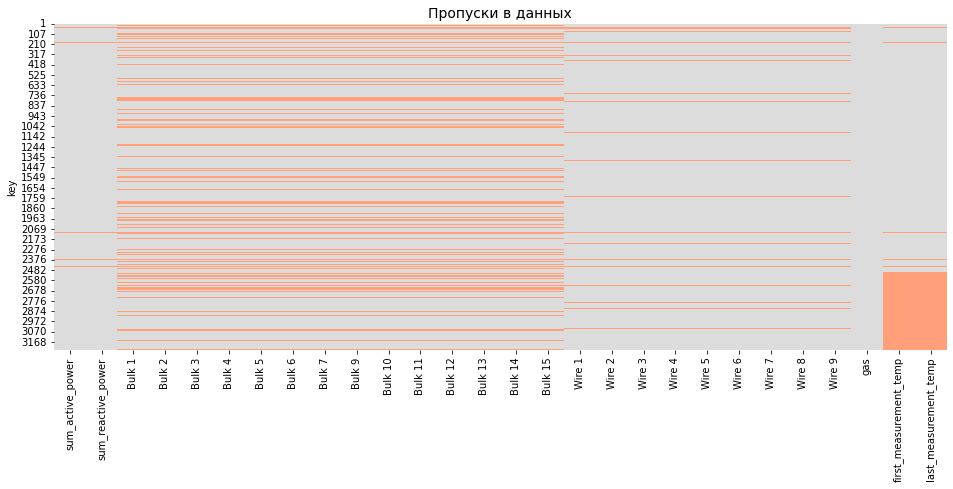

In [48]:
colours = ['Gainsboro', 'LightSalmon'] 
plt.figure(figsize=(16, 6))
sns.heatmap(data.isnull(), cmap=sns.color_palette(colours), cbar = False)
plt.title('Пропуски в данных', fontsize=14)
data.isna().mean().map('{:,.1%}'.format)

In [49]:
data.isna().mean().map('{:,.1%}'.format)

sum_active_power           0.9%
sum_reactive_power         0.9%
Bulk 1                    24.0%
Bulk 2                    24.0%
Bulk 3                    24.0%
Bulk 4                    24.0%
Bulk 5                    24.0%
Bulk 6                    24.0%
Bulk 7                    24.0%
Bulk 9                    24.0%
Bulk 10                   24.0%
Bulk 11                   24.0%
Bulk 12                   24.0%
Bulk 13                   24.0%
Bulk 14                   24.0%
Bulk 15                   24.0%
Wire 1                     4.9%
Wire 2                     4.9%
Wire 3                     4.9%
Wire 4                     4.9%
Wire 5                     4.9%
Wire 6                     4.9%
Wire 7                     4.9%
Wire 8                     4.9%
Wire 9                     4.9%
gas                        0.1%
first_measurement_temp    24.6%
last_measurement_temp     24.6%
dtype: object

In [50]:
data.dropna(inplace = True)
data

,sum_active_power,sum_reactive_power,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,gas,first_measurement_temp,last_measurement_temp
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.878147,3.183241,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986,1571.0,1613.0
2,3.052598,1.998112,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561,1581.0,1602.0
3,2.525882,1.599076,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793,1596.0,1599.0
4,3.209250,2.060298,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219,1601.0,1625.0
5,3.347173,2.252643,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692,1576.0,1602.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,3.210690,2.360777,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.125735,1570.0,1591.0
2496,4.203064,2.810185,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.412616,1554.0,1591.0
2497,2.212379,1.851269,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.271699,1571.0,1589.0


Все данные подготовлены

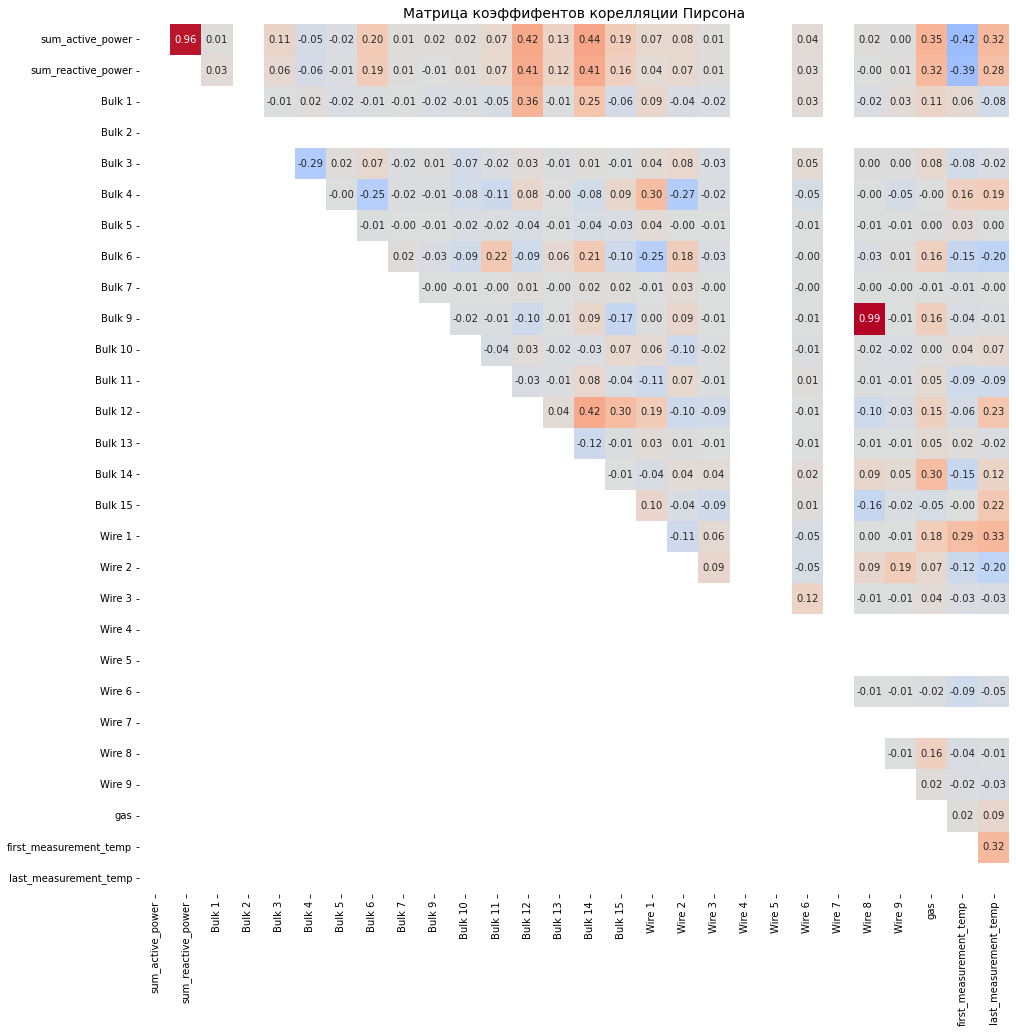

In [51]:
# зададим размер
plt.figure(figsize=(16,16))
# cоздадим массив из коэффициентов корелляций Пирсона и отрежем данные ниже диагонали
mask = np.tril(data.corr())
# построим график
sns.heatmap(data.corr(),
            cmap='coolwarm', center=0, annot=True, mask = mask, cbar = False, square = True, fmt = '.2f')
plt.title('Матрица коэффифентов корелляции Пирсона', fontsize=14)
plt.show()

In [52]:
data.drop(columns = ['Bulk 2', 'Wire 4', 'Wire 5', 'Wire 7'], inplace = True)

Мультиколлинеарность негативно влияет на модели машинного обучения. 
Наибольшая корелляция по признакам
- sum_active_power и sum_reactive_power
- Bulk 9 и Wire 8

# Устранение мультиколлениарности

In [53]:
RS = 120922

In [54]:
def LR(features, target):
    #Сформируем обучающие и тестовые выборки
    features_train, features_test, target_train, target_test = \
        train_test_split(features, target, test_size = 0.25, random_state = RS)
    #масштабируем признаки
    scaler = StandardScaler()
    scaler.fit(features_train)
    features_train = scaler.transform(features_train)
    features_test = scaler.transform(features_test)

    model_LR = LinearRegression()
    model_LR.fit(features_train, target_train)
    scores_LR = cross_val_score(model_LR, features_train, target_train, 
                                cv = 5, scoring = 'neg_mean_absolute_error')

    return abs(scores_LR.mean())

In [55]:
corr =pd.DataFrame(columns = ['drop_features', 'MAE_score'])
target = data['last_measurement_temp']
support_features = data.drop(columns = ['last_measurement_temp'])
corr = corr.append({'drop_features': 'nope_drope', 
                        'MAE_score': LR(support_features, target)}, ignore_index = True)

for feature_drop in list(data.columns)[:-1]:
    
    support_features = data.drop(columns = ['last_measurement_temp', feature_drop])

    corr = corr.append({'drop_features':feature_drop, 
                        'MAE_score': LR(support_features, target)}, ignore_index = True)
    
corr['delta_MAE'] = (([-corr.iloc[0,1]] * len(corr) + corr['MAE_score'])/ corr.iloc[0,1]).map('{:,.1%}'.format)
corr

,drop_features,MAE_score,delta_MAE
0,nope_drope,7.621928,0.0%
1,sum_active_power,8.463966,11.0%
2,sum_reactive_power,8.011977,5.1%
3,Bulk 1,6.000199,-21.3%
4,Bulk 3,7.650174,0.4%
5,Bulk 4,7.647407,0.3%
6,Bulk 5,7.881526,3.4%
7,Bulk 6,8.305080,9.0%
8,Bulk 7,5.959562,-21.8%
9,Bulk 9,8.259566,8.4%


Удалим признаки снижающие МАЕ: 

In [56]:
data.drop(columns = ['Bulk 1','Bulk 7', 'Wire 3', 'gas'], inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1730 entries, 1 to 2499
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   sum_active_power        1730 non-null   float64
 1   sum_reactive_power      1730 non-null   float64
 2   Bulk 3                  1730 non-null   float64
 3   Bulk 4                  1730 non-null   float64
 4   Bulk 5                  1730 non-null   float64
 5   Bulk 6                  1730 non-null   float64
 6   Bulk 9                  1730 non-null   float64
 7   Bulk 10                 1730 non-null   float64
 8   Bulk 11                 1730 non-null   float64
 9   Bulk 12                 1730 non-null   float64
 10  Bulk 13                 1730 non-null   float64
 11  Bulk 14                 1730 non-null   float64
 12  Bulk 15                 1730 non-null   float64
 13  Wire 1                  1730 non-null   float64
 14  Wire 2                  1730 non-null   

In [57]:
features = data.drop(columns = ['last_measurement_temp'])

# Обучение модели

In [58]:
results_df =pd.DataFrame(columns = ['model', 'CV_MAE_score'])

#Сформируем обучающие и тестовые выборки
features_train, features_test, target_train, target_test = \
        train_test_split(features, target, test_size = 0.25, random_state = RS)

## LinearRegression

In [59]:
#масштабируем признаки
scaler = StandardScaler()
scaler.fit(features_train)
features_train_ = scaler.transform(features_train)
features_test_lr = scaler.transform(features_test)


model_LR = LinearRegression()
model_LR.fit(features_train, target_train)
scores_LR = cross_val_score(model_LR, features_train, target_train, 
                            cv = 5, scoring = 'neg_mean_absolute_error')

results_df = results_df.append({'model':'LinearRegression', 
                                'CV_MAE_score': abs(scores_LR.mean()) }, 
                                 ignore_index = True)
results_df

,model,CV_MAE_score
0,LinearRegression,6.072937


##  Random Forest Regressor

In [60]:
%%time
params = {'n_estimators': [30, 50, 100, 200],
         #'max_features': ['sqrt','log2'],
          'max_depth' : [3, 5, 10],
          'random_state' : [RS]}

RFR = GridSearchCV(estimator = RandomForestRegressor(random_state = RS), 
                      param_grid = params, cv= 5, 
                      scoring = 'neg_mean_absolute_error')

RFR.fit(features_train, target_train)
best_RFR = RFR.best_estimator_

CPU times: user 14.9 s, sys: 440 ms, total: 15.4 s
Wall time: 14.3 s


In [61]:
results_df = results_df.append({'model':'RandomForestRegressor', 
                                'CV_MAE_score': abs(RFR.best_score_)}, 
                                 ignore_index = True)
results_df

,model,CV_MAE_score
0,LinearRegression,6.072937
1,RandomForestRegressor,6.019041


## LightGBM

In [62]:
%%time
LGBMR = LGBMRegressor(random_state = RS)
cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = RS)

LGBMR.fit(features_train, target_train)

scores_LGBM = cross_val_score(LGBMR, features_train, target_train, 
                              scoring='neg_mean_absolute_error', cv = cv, n_jobs=-1, 
                              error_score='raise')

CPU times: user 1.83 s, sys: 517 ms, total: 2.34 s
Wall time: 1.75 s


In [63]:
results_df = results_df.append({'model':'LGBMRegressor', 
                                'CV_MAE_score': abs(scores_LGBM.mean())}, 
                                ignore_index = True)
results_df

,model,CV_MAE_score
0,LinearRegression,6.072937
1,RandomForestRegressor,6.019041
2,LGBMRegressor,6.071071


## XGBoost

In [64]:
%%time
housing_dmatrix = xgb.DMatrix(data=features_train, label=target_train)
            
params = {'colsample_bytree': [0.9, 1], #0.7
          'n_estimators': [400, 500], #100
          'max_depth': [2, 5], #, 10
     #    'reg_alpha': [1.1, 1.2, 1.3],
     #    'reg_lambda': [1.1, 1.2, 1.3],
          'subsample': [0.7, 0.8, 0.9],
          'learning_rate': [0.01, 0.05, 0.1]}
 
XGBR = GridSearchCV(xgb.XGBRegressor(random_state = RS), cv=3, verbose=1, 
                        param_grid = params,
                        scoring = 'neg_mean_absolute_error')
XGBR.fit(features_train, target_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
CPU times: user 5min 55s, sys: 1min, total: 6min 55s
Wall time: 58.4 s


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                              

In [65]:
results_df = results_df.append({'model':'XGBRegressor', 
                                'CV_MAE_score': abs(XGBR.best_score_)}, 
                                 ignore_index = True)
best_XGBR = XGBR.best_estimator_
results_df

,model,CV_MAE_score
0,LinearRegression,6.072937
1,RandomForestRegressor,6.019041
2,LGBMRegressor,6.071071
3,XGBRegressor,5.876598


In [66]:
XGBR.best_params_

{'colsample_bytree': 1,
 'learning_rate': 0.05,
 'max_depth': 2,
 'n_estimators': 400,
 'subsample': 0.7}

## Catboost

In [67]:
%%time
params = {'depth': [2, 5, 8, 25],
          'learning_rate' : [0.01, 0.1, 0.2],
          'iterations'    : [5, 300, 400]
        }
CBR = GridSearchCV(estimator=CatBoostRegressor(random_state = RS), 
                   param_grid = params, cv = 3, n_jobs=-1,
                   scoring = 'neg_mean_absolute_error')
CBR.fit(features_train, target_train)   

CBR.best_params_

0:	learn: 10.5959689	total: 59.4ms	remaining: 238ms
1:	learn: 10.5759770	total: 59.9ms	remaining: 89.9ms
2:	learn: 10.5586312	total: 60.2ms	remaining: 40.1ms
3:	learn: 10.5438595	total: 60.5ms	remaining: 15.1ms
4:	learn: 10.5255432	total: 60.9ms	remaining: 0us
0:	learn: 10.6260535	total: 472us	remaining: 141ms
1:	learn: 10.6179834	total: 976us	remaining: 146ms
2:	learn: 10.6075640	total: 1.3ms	remaining: 129ms
3:	learn: 10.5964447	total: 1.78ms	remaining: 132ms
4:	learn: 10.5844627	total: 2.1ms	remaining: 124ms
5:	learn: 10.5673072	total: 2.34ms	remaining: 115ms
6:	learn: 10.5483635	total: 2.62ms	remaining: 110ms
7:	learn: 10.5300909	total: 3.23ms	remaining: 118ms
8:	learn: 10.5174436	total: 3.67ms	remaining: 119ms
9:	learn: 10.5038928	total: 4.25ms	remaining: 123ms
10:	learn: 10.4898543	total: 4.75ms	remaining: 125ms
11:	learn: 10.4783243	total: 5ms	remaining: 120ms
12:	learn: 10.4670427	total: 5.86ms	remaining: 129ms
13:	learn: 10.4507244	total: 6.19ms	remaining: 126ms
14:	learn: 10.

/Users/vladimirgavrilev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
27 fits failed out of a total of 108.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/vladimirgavrilev/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vladimirgavrilev/opt/anaconda3/lib/python3.9/site-packages/catboost/core.py", line 5590, in fit
    return self._fit(X, y, cat_features, None, None, None, sample_weight, None, None, None, None, baseline,
  File "/Users/vladimirgavrilev/opt/anaconda

53:	learn: 7.0185517	total: 100ms	remaining: 456ms
54:	learn: 7.0058517	total: 101ms	remaining: 450ms
55:	learn: 7.0012927	total: 102ms	remaining: 443ms
56:	learn: 6.9855985	total: 102ms	remaining: 437ms
57:	learn: 6.9768843	total: 103ms	remaining: 430ms
58:	learn: 6.9683100	total: 104ms	remaining: 425ms
59:	learn: 6.9551656	total: 105ms	remaining: 420ms
60:	learn: 6.9364149	total: 106ms	remaining: 414ms
61:	learn: 6.9278222	total: 106ms	remaining: 409ms
62:	learn: 6.9049011	total: 107ms	remaining: 404ms
63:	learn: 6.8959198	total: 108ms	remaining: 400ms
64:	learn: 6.8772454	total: 109ms	remaining: 395ms
65:	learn: 6.8709117	total: 110ms	remaining: 390ms
66:	learn: 6.8544801	total: 111ms	remaining: 386ms
67:	learn: 6.8313763	total: 112ms	remaining: 381ms
68:	learn: 6.8130733	total: 113ms	remaining: 377ms
69:	learn: 6.8062862	total: 113ms	remaining: 372ms
70:	learn: 6.7960000	total: 114ms	remaining: 368ms
71:	learn: 6.7805828	total: 115ms	remaining: 364ms
72:	learn: 6.7562102	total: 115

{'depth': 5, 'iterations': 300, 'learning_rate': 0.1}

In [68]:
results_df = results_df.append({'model':'CatBoostRegressor', 
                                'CV_MAE_score': abs(CBR.best_score_)}, 
                                 ignore_index = True)
best_CBR = CBR.best_estimator_

results_df

,model,CV_MAE_score
0,LinearRegression,6.072937
1,RandomForestRegressor,6.019041
2,LGBMRegressor,6.071071
3,XGBRegressor,5.876598
4,CatBoostRegressor,5.852427


Мы провели обучение с примением следующих моделей машинного обучения

In [69]:
results_df

,model,CV_MAE_score
0,LinearRegression,6.072937
1,RandomForestRegressor,6.019041
2,LGBMRegressor,6.071071
3,XGBRegressor,5.876598
4,CatBoostRegressor,5.852427


С точки зрения качества предсказания по МАЕ на этапе кросс-валидации однозначно победа за моделями XGBoostRegressor и CatboostRegressor

#  Результат на тестовой выборке

Оценим результаты топ 2 моделя на тествовой выборке:

In [70]:
target_predict = best_XGBR.predict(features_test)
print('MAE on test of XGBoostRegressor =', mean_absolute_error(target_predict, target_test))

target_predict = best_CBR.predict(features_test)
print('MAE on test of CatoosbtRegressor =', mean_absolute_error(target_predict, target_test))

MAE on test of XGBoostRegressor = 5.866741788304705
MAE on test of CatoosbtRegressor = 6.11026553186646


# Вывод

Итак, мы выполнили проект по определению оптимальной температуры после достижения целевого химического состава.

- Разобрались в процессе легирования стали. При предобработке не оставили без внимания детекцию аномалий и выбросов, их было не много (выбросы по температуре и мощностям). Данные подготовлены хорошо.

- Мощностя агрегировали накопленным итогом, времена удалили из датасета, для целей задачи они нам понадибились только для отбраковки наблюдений по времени замеров-  удалось выявить 129 аномальных партий.

- На первый взгляд, среди данных достаточно много признаков для обучения. Однако после предобработки, количество убавилось с 37 до 19 по наличию значительных пропусков и мультиколлинеарности. 

- По результатам обучения моделей, метрика по МАЕ лучше у градиентных бустингов. 

Лучший результат на кросс-валидации у XGBoost - МАЕ 5.87 и CatBoost - 5.85 градусов. На тестовой выборке модели достигнуты следующие значения МАЕ __5.86 и 6.11__ соответственно. 
Достаточно высокая точность при конечной температуре порядка 1500 градусов. Цель по метрике МАЕ достигнута XGBoost-ом (6 градусов).

_Основная трудность была с feature инжинирингом. Чтобы достичь наиболее высоких результатов по МАЕ на кросс-валидации пришлось на модели линейной регрессии проверить веса каждой из фичи. Сокращение признаков улучшил МАЕ практически на 1.8 МАЕ единиц от номинальной модели (имеется ввиду линейная регрессия без удаления признаков).